In [1]:
# load useful packages
require(ggplot2)
require(xcms)
require(reshape2)  # for colsplit
require(gdata)  # for reading .xlxs
require(stringr)
require(ecipex)
require(cowplot)


Loading required package: ggplot2
Loading required package: xcms
Loading required package: mzR
Loading required package: Rcpp
Warning message:
In fun(libname, pkgname): mzR has been built against a different Rcpp version (0.12.1)
than is installed on your system (0.12.3). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following obj

In [2]:

# change to directory with Colin's data
setwd('/Users/curt/stanford/data/2012-12-04_old_data_from_CH/all_mzXML_files')

# tell xcms about the mzXML files
my_files <- list.files(pattern='*.mzXML')

print(my_files)

 [1] "batch_convert_mzXML_to_mzML.sh" "P2-1_150513.mzXML"             
 [3] "P2-10_150513.mzXML"             "P2-11_150513.mzXML"            
 [5] "P2-12_150513.mzXML"             "P2-13_150513.mzXML"            
 [7] "P2-14_150513.mzXML"             "P2-15_150513.mzXML"            
 [9] "P2-16_150513.mzXML"             "P2-17_150513.mzXML"            
[11] "P2-18_150513.mzXML"             "P2-19_150513.mzXML"            
[13] "P2-2_150513.mzXML"              "P2-20_150513.mzXML"            
[15] "P2-21_150513.mzXML"             "P2-22_150513.mzXML"            
[17] "P2-23_150513.mzXML"             "P2-24_150513.mzXML"            
[19] "P2-3_150513.mzXML"              "P2-4_150513.mzXML"             
[21] "P2-5_150513.mzXML"              "P2-6_150513.mzXML"             
[23] "P2-7_150513.mzXML"              "P2-8_150513.mzXML"             
[25] "P2-9_150513.mzXML"              "S2-1_150513.mzXML"             
[27] "S2-10_150513.mzXML"             "S2-11_150513.mzXML"            
[29] "

In [3]:
# # make the xSet using default parameters and save results
# xset <- xcmsSet(my_files)
# save(xset, file='default_xcmsSet_48_files.rdat')

load('default_xcmsSet_48_files.rdat')

ls()

[1] "my_files" "xset"

In [4]:
# read excel table that defines strain from sample
strain_by_sample <- read.xls('150528_sample_descriptions.xlsx')[, 1:2]
names(strain_by_sample)[1] <- 'sample_num'

strain_by_sample

,sample_num,Strain
1,1,13
2,2,13
3,3,13
4,4,14
5,5,14
6,6,14
7,7,15
8,8,15
9,9,15
10,10,16


In [5]:
bergmotene_H_plus <- 'C15H25'
bergmotenol_H_plus <- 'C15H27O'
bergmotenol_Na_plus <- 'C15H26ONa'
mass_of_electron <- 0.000548579909

bergmotene_mz <- ecipex(bergmotene_H_plus)[[1]]$mass[1] - mass_of_electron
bergmotenol_mz <- ecipex(bergmotenol_H_plus)[[1]]$mass[1] - mass_of_electron
bergmotenol_Na_mz <- ecipex(bergmotenol_Na_plus)[[1]]$mass[1] - mass_of_electron

print(c(bergmotene_mz, bergmotenol_mz, bergmotenol_Na_mz))

[1] 205.1951 223.2056 245.1876


$$\require{mhchem}$$   
## "Bergmotene" $\cf{C15H25+}$

In [6]:
# get EICs for bergmotene

mz_tol <- 0.01
mz_range <- c(bergmotene_mz - mz_tol, bergmotene_mz + mz_tol)
myEICs <- getEIC(xset, mzrange=t(matrix(mz_range)))

# convert EIC data to data frame
my_eic_dat <- data.frame(sample_name = c(), 
                         retention_time_s = c(),
                         inteansity = c())
for(idx in 1:length(myEICs@eic)){
    rts <- myEICs@eic[[idx]][[1]][, 1]
    ints <- myEICs@eic[[idx]][[1]][, 2]
    num_points <- length(rts)
    sample_names <- rep(names(myEICs@eic[idx]), num_points)
    df <- data.frame(sample_name = sample_names, 
                     retention_time_s = rts,
                     intensity = ints)
    my_eic_dat <- rbind(df, my_eic_dat)
    }

# define fraction
my_eic_dat$fraction <- substr(as.character(my_eic_dat$sample_name), 1, 1)

# define sample #
foo <- str_split_fixed(as.character(my_eic_dat$sample_name), '-', n=2)[, 2]
my_eic_dat$sample_num <- str_split_fixed(as.character(foo), '_', n=2)[, 1]
my_eic_dat$sample_num <- as.numeric(my_eic_dat$sample_num)
my_eic_dat$rt_min <- my_eic_dat$retention_time_s / 60

my_eic_dat_b <- merge(my_eic_dat, strain_by_sample, by='sample_num')


P2-1_150513 P2-10_150513 P2-11_150513 P2-12_150513 P2-13_150513 P2-14_150513 P2-15_150513 P2-16_150513 P2-17_150513 P2-18_150513 P2-19_150513 P2-2_150513 P2-20_150513 P2-21_150513 P2-22_150513 P2-23_150513 P2-24_150513 P2-3_150513 P2-4_150513 P2-5_150513 P2-6_150513 P2-7_150513 P2-8_150513 P2-9_150513 S2-1_150513 S2-10_150513 S2-11_150513 S2-12_150513 S2-13_150513 S2-14_150513 S2-15_150513 S2-16_150513 S2-17_150513 S2-18_150513 S2-19_150513 S2-2_150513 S2-20_150513 S2-21_150513 S2-22_150513 S2-23_150513 S2-24_150513 S2-3_150513 S2-4_150513 S2-5_150513 S2-6_150513 S2-7_150513 S2-8_150513 S2-9_150513 


## "Bergmotenol" $\cf{C15H27O+}$

In [7]:
# get EICs for bergmotenol

mz_tol <- 0.01
mz_range <- c(bergmotenol_mz - mz_tol, bergmotenol_mz + mz_tol)
myEICs <- getEIC(xset, mzrange=t(matrix(mz_range)))

# convert EIC data to data frame
my_eic_dat <- data.frame(sample_name = c(), 
                         retention_time_s = c(),
                         inteansity = c())
for(idx in 1:length(myEICs@eic)){
    rts <- myEICs@eic[[idx]][[1]][, 1]
    ints <- myEICs@eic[[idx]][[1]][, 2]
    num_points <- length(rts)
    sample_names <- rep(names(myEICs@eic[idx]), num_points)
    df <- data.frame(sample_name = sample_names, 
                     retention_time_s = rts,
                     intensity = ints)
    my_eic_dat <- rbind(df, my_eic_dat)
    }

# define fraction
my_eic_dat$fraction <- substr(as.character(my_eic_dat$sample_name), 1, 1)

# define sample #
foo <- str_split_fixed(as.character(my_eic_dat$sample_name), '-', n=2)[, 2]
my_eic_dat$sample_num <- str_split_fixed(as.character(foo), '_', n=2)[, 1]
my_eic_dat$sample_num <- as.numeric(my_eic_dat$sample_num)
my_eic_dat$rt_min <- my_eic_dat$retention_time_s / 60

my_eic_dat_boh <- merge(my_eic_dat, strain_by_sample, by='sample_num')

P2-1_150513 P2-10_150513 P2-11_150513 P2-12_150513 P2-13_150513 P2-14_150513 P2-15_150513 P2-16_150513 P2-17_150513 P2-18_150513 P2-19_150513 P2-2_150513 P2-20_150513 P2-21_150513 P2-22_150513 P2-23_150513 P2-24_150513 P2-3_150513 P2-4_150513 P2-5_150513 P2-6_150513 P2-7_150513 P2-8_150513 P2-9_150513 S2-1_150513 S2-10_150513 S2-11_150513 S2-12_150513 S2-13_150513 S2-14_150513 S2-15_150513 S2-16_150513 S2-17_150513 S2-18_150513 S2-19_150513 S2-2_150513 S2-20_150513 S2-21_150513 S2-22_150513 S2-23_150513 S2-24_150513 S2-3_150513 S2-4_150513 S2-5_150513 S2-6_150513 S2-7_150513 S2-8_150513 S2-9_150513 


## "Bergmotenol" $\cf{C15H26ONa+}$

In [8]:
# get EICs for bergmotenol

mz_tol <- 0.01
mz_range <- c(bergmotenol_Na_mz - mz_tol, bergmotenol_Na_mz + mz_tol)
myEICs <- getEIC(xset, mzrange=t(matrix(mz_range)))

# convert EIC data to data frame
my_eic_dat <- data.frame(sample_name = c(), 
                         retention_time_s = c(),
                         inteansity = c())
for(idx in 1:length(myEICs@eic)){
    rts <- myEICs@eic[[idx]][[1]][, 1]
    ints <- myEICs@eic[[idx]][[1]][, 2]
    num_points <- length(rts)
    sample_names <- rep(names(myEICs@eic[idx]), num_points)
    df <- data.frame(sample_name = sample_names, 
                     retention_time_s = rts,
                     intensity = ints)
    my_eic_dat <- rbind(df, my_eic_dat)
    }

# define fraction
my_eic_dat$fraction <- substr(as.character(my_eic_dat$sample_name), 1, 1)

# define sample #
foo <- str_split_fixed(as.character(my_eic_dat$sample_name), '-', n=2)[, 2]
my_eic_dat$sample_num <- str_split_fixed(as.character(foo), '_', n=2)[, 1]
my_eic_dat$sample_num <- as.numeric(my_eic_dat$sample_num)
my_eic_dat$rt_min <- my_eic_dat$retention_time_s / 60

my_eic_dat_bna <- merge(my_eic_dat, strain_by_sample, by='sample_num')

P2-1_150513 P2-10_150513 P2-11_150513 P2-12_150513 P2-13_150513 P2-14_150513 P2-15_150513 P2-16_150513 P2-17_150513 P2-18_150513 P2-19_150513 P2-2_150513 P2-20_150513 P2-21_150513 P2-22_150513 P2-23_150513 P2-24_150513 P2-3_150513 P2-4_150513 P2-5_150513 P2-6_150513 P2-7_150513 P2-8_150513 P2-9_150513 S2-1_150513 S2-10_150513 S2-11_150513 S2-12_150513 S2-13_150513 S2-14_150513 S2-15_150513 S2-16_150513 S2-17_150513 S2-18_150513 S2-19_150513 S2-2_150513 S2-20_150513 S2-21_150513 S2-22_150513 S2-23_150513 S2-24_150513 S2-3_150513 S2-4_150513 S2-5_150513 S2-6_150513 S2-7_150513 S2-8_150513 S2-9_150513 


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
: Removed 71968 rows containing missing values (geom_path).Warning message:
: Removed 71968 rows containing missing values (geom_path).Warning message:
: Removed 71968 rows containing missing values (geom_path).

,sample_num,Strain
1,1,13
2,2,13
3,3,13
4,4,14
5,5,14
6,6,14
7,7,15
8,8,15
9,9,15
10,10,16


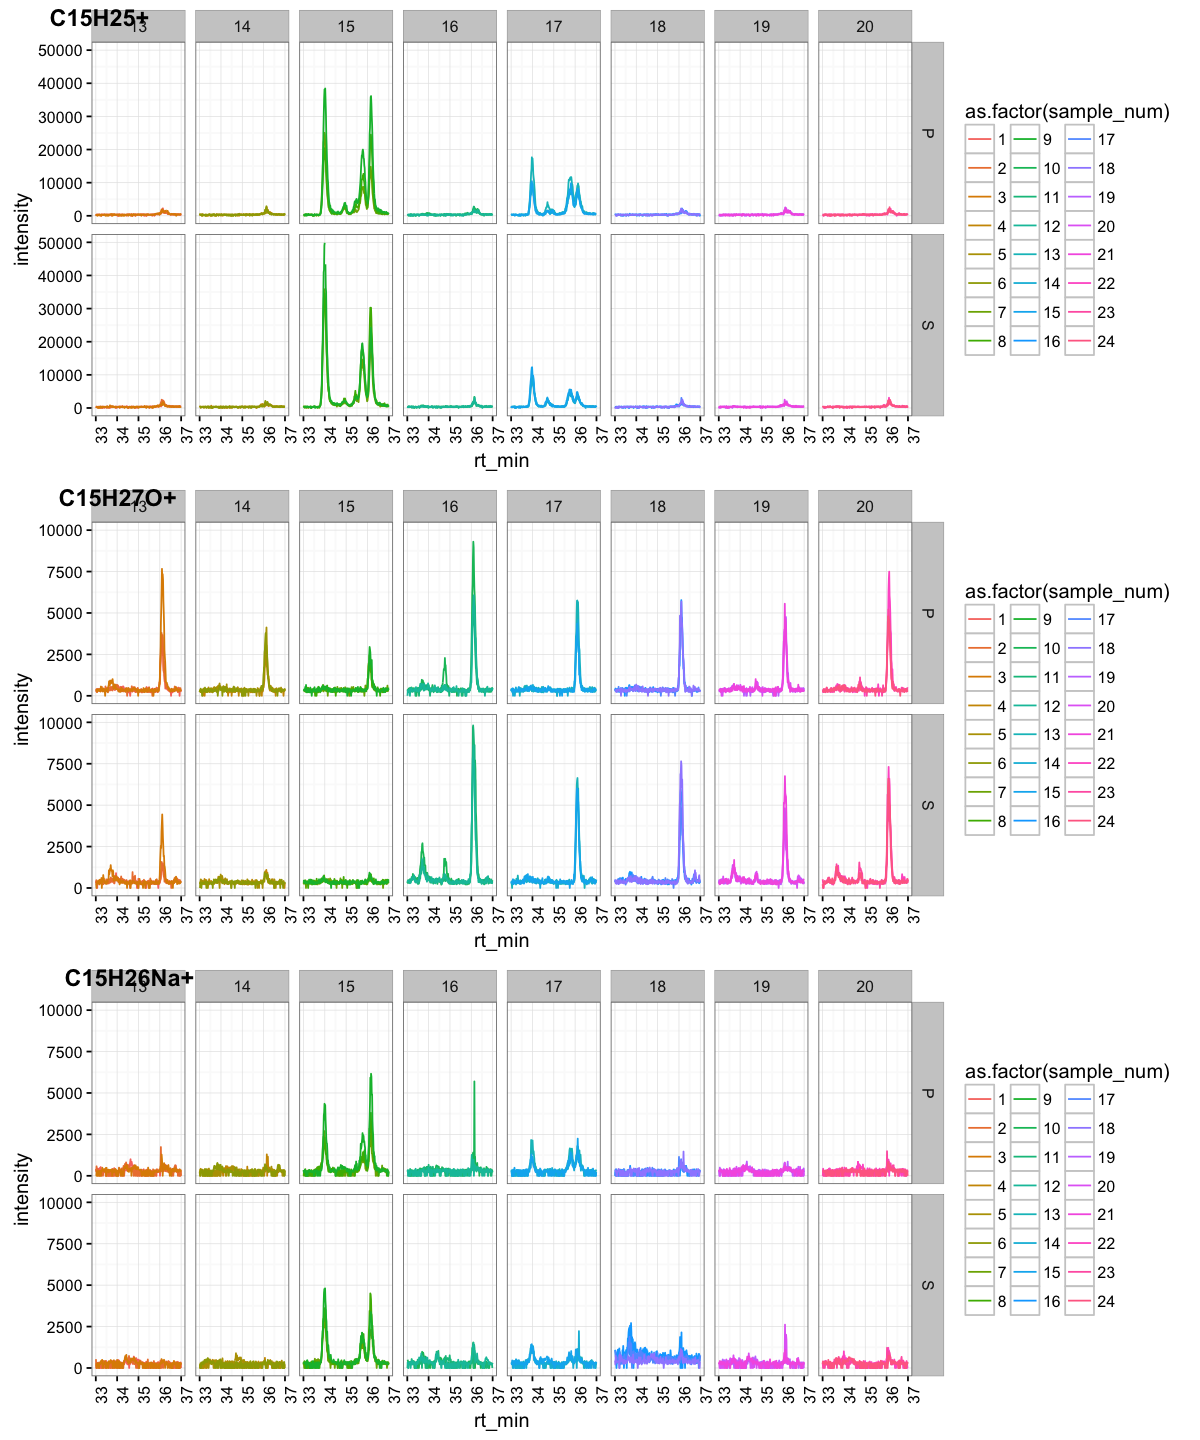

In [12]:
options(repr.plot.width=10, repr.plot.height=12)
p <- ggplot(data=my_eic_dat_b, aes(x=rt_min, y=intensity, color=as.factor(sample_num))) + 
    geom_line() + 
    facet_grid(fraction~Strain, scale='free_y') + 
    guides(col = guide_legend(nrow=8)) +
    theme_bw() + 
    xlim(33, 37) +
    theme(axis.text.x = element_text(angle = 90)) +
    ylim(0, 50000)

q <- p %+% my_eic_dat_boh + ylim(0, 10000)

s <- p %+% my_eic_dat_bna + ylim(0, 10000)

plot_grid(p, q, s, ncol=1, labels=c('C15H25+', 'C15H27O+', 'C15H26Na+'))

strain_by_sample